# Chapter 15: Macromolecular Structures
***

In [1]:
# function for Obtaining structure data

from urllib.request import urlopen

# %s indicating where the database identifier will be inserted
#PDB_URL = 'http://files.rcsb.org/header/%s.pdb?format=PDB&compression=None'
PDB_URL = 'https://files.rcsb.org/download/%s.pdb'
# function to download pdb file 
def downloadPDB(pdbId, fileName=None):
    
    if not fileName:
        fileName = '%s.pdb' % pdbId
        
    response = urlopen(PDB_URL % pdbId)
    data = response.read().decode('utf-8')
    
    fileObj = open(fileName, 'w')
    fileObj.write(data)
    fileObj.close()
    
    return fileName

In [2]:
# Obtaining PDB File information
import pypdb # for performing searches with the RCSB PDB

# describe the pdb file using pypdb before downloading 
pypdb.describe_pdb('1A3N')

{'audit_author': [{'name': 'Tame, J.', 'pdbx_ordinal': 1},
  {'name': 'Vallone, B.', 'pdbx_ordinal': 2}],
 'cell': {'angle_alpha': 90.0,
  'angle_beta': 99.61,
  'angle_gamma': 90.0,
  'length_a': 62.65,
  'length_b': 82.43,
  'length_c': 53.53,
  'zpdb': 4},
 'citation': [{'country': 'DK',
   'id': 'primary',
   'journal_abbrev': 'Acta Crystallogr.,Sect.D',
   'journal_id_astm': 'ABCRE6',
   'journal_id_csd': '0766',
   'journal_id_issn': '0907-4449',
   'journal_volume': '56',
   'page_first': '805',
   'page_last': '811',
   'pdbx_database_id_doi': '10.1107/S0907444900006387',
   'pdbx_database_id_pub_med': 10930827,
   'rcsb_authors': ['Tame, J.R.', 'Vallone, B.'],
   'rcsb_is_primary': 'Y',
   'rcsb_journal_abbrev': 'Acta Crystallogr D Biol Crystallogr',
   'title': 'The structures of deoxy human haemoglobin and the mutant Hb Tyralpha42His at 120 K.',
   'year': 2000}],
 'diffrn': [{'ambient_temp': 120.0, 'crystal_id': '1', 'id': '1'}],
 'diffrn_detector': [{'details': 'MIRROR',
 

In [3]:
# Download PDB file into current directory
fileName = downloadPDB('1A3N')
print(fileName)

1A3N.pdb


In [4]:
from numpy import zeros

# finds the center of mass (centroid) of a structure

ATOMIC_NUMS = {'H':1.0, 'C':12.0, 'N':14.0, 'O':16.0, 'P':31.0, 'S':32.0}

def getCenterOfMass(structure):
    
    centerOfMass = zeros(3, float)
    totalMass = 0.0
    
    for chain in structure.chains:
        for residue in chain.residues:
            for atom in residue.atoms:
                mass = ATOMIC_NUMS.get(atom.element, 12.0)
                centerOfMass += mass * atom.coords
                totalMass += mass
                
    centerOfMass /= totalMass
    
    return centerOfMass

In [5]:
# contains Structure Class from book examples
# used to create a structure from a pdb file 
from Modelling import getStructuresFromFile, Structure, Chain, Residue, Atom

strucObjs = getStructuresFromFile('examples/1A12.pdb')

structure = getStructuresFromFile('examples/1A12.pdb')[0]

print(getCenterOfMass(structure))

[18.88902365  0.32533332  1.24039978]


In [6]:
from numpy import array, dot
from Maths import getRotationMatrix
from math import pi

# rotate structure along xyz with given angle 
def rotateStructure(structure, axis=(1,0,0), angle=0):
    
    rMatrix = array(getRotationMatrix(axis, angle))
    
    for chain in structure.chains:
        for residue in chain.residues:
            for atom in residue.atoms:
                newCoords = dot(rMatrix, atom.coords)
                atom.coords = newCoords
# since structure is rotated internally, nothing needs to be returned
# structure object itself is altered 
rotateStructure(structure, (0,1,0), pi/2)

In [7]:
from numpy import array, dot

def getAtomCoords(structure):
    
    coords = []
    atoms = []
    
    for chain in structure.chains:
        for residue in chain.residues:
            for atom in residue.atoms:
                coords.append(atom.coords)
                atoms.append(atom)
                
    return atoms, array(coords)         

In [8]:
# roatates structure like rotateStructure()
# innards are more simple, avoids using loops 
# uses one 2d numpy array for all the coordinates 

from math import pi

def rotateStructureNumPy(structure, axis=array([1,0,0]), angle=0):
    
    rMatrix = array(getRotationMatrix(axis, angle))
    
    atoms, coords = getAtomCoords(structure)
    
    coords = dot(coords, rMatrix.T) #transpose 
    
    for index, atom in enumerate(atoms):
        atom.coords = list(coords[index])
        
rotateStructureNumPy(structure, (0,1,0), pi/2)

In [9]:
# affine transformation example
# includes transformation matrix
# transformation matrix may be used to stretch, reflect, shrink, enlarge and rotate the structure

from numpy import identity # used for identity matrix

# default for the translation is a vector of zeros; so no movement occurs.
def affineTransformStructure(structure, transform=identity(3),
                                  translate=(0,0,0)):
    atoms, coords = getAtomCoords(structure)
    
    coords = dot(coords, transform.T)
    
    coords = coords + translate
    
    for index, atom in enumerate(atoms):
        atom.coords = coords[index]
        
# transformation examples:

# array to mirror the structure
mirrorTransform = array([[-1,0,0], [0,-1,0], [0,0,-1]])

# array to move 10units along x and y axis 
translate = array([10.0, 10.0, 0.0])

# call function and apply arrays to structure for transformation
affineTransformStructure(structure, mirrorTransform, translate)

# write the transformation of the structure to a new pdb file 
from Structures import writeStructureToFile
writeStructureToFile(structure, 'testTransform.pdb')


Cannot find license file.
 The license files (or license server system network addresses) attempted are 
listed below.  Use LM_LICENSE_FILE to use a different license file,
 or contact your software provider for a license file.
Feature:       PYMOL_MAIN
Filename:      /Library/Application Support/Schrodinger/licenses
License path:  /Library/Application Support/Schrodinger/licenses:
FlexNet Licensing error:-1,359.  System Error: 2 "No such file or directory"


In [10]:
# calculating atomic distances and torsion angles (dihedral angles)

from math import sqrt

# basic example:
#deltas = atomA.coords - atomB.coords
#sumSquares = dot(deltas, deltas)
#distance = sqrt(sumSquares)

def findCloseAtoms(structure, xyz, limit=5.0):
    
    closeAtoms = []
    xyz = array(xyz)
    atoms, coords = getAtomCoords(structure)
    limit2 = limit * limit
    
    deltas = coords - xyz
    squares = deltas * deltas
    sumSquares = squares.sum(axis=1)
    
    boolArray = sumSquares < limit2
    indices = boolArray.nonzero()[0] # array for first and only axis
    
    closeAtoms = [atoms[i] for i in indices]
    
    return closeAtoms

atoms = findCloseAtoms(structure, (18.89, 0.36, 1.24), 5.0)
for atom in atoms:
    print(atom.residue.code, atom.name)

THR OG1
LYS C
LYS O
ASP N
ASP CA
ASP C
ASP O
ASP CB
ASP CG
ASP OD1
ASP OD2


In [11]:
# calculate the twist angle between atoms
# imagined as a group of four atoms in a rough rectangle
# connected by three bonds so that three edges are connected and one edge is not.
# angle being measured is the amount of twist between the first and last bonds, around the central bond

from Maths import calcTorsionAngle
from math import degrees

def getPhiPsi(residue, inDegrees=True):
    
    phi = None
    psi = None
    
    # gets list of all residues in input residue’s chain
    chain = residue.chain
    residues = chain.residues
    
    atomN = residue.getAtom('N')
    atomCa = residue.getAtom('CA')
    atomC = residue.getAtom('C')
    
    coordsN = atomN.coords
    coordsCa = atomCa.coords
    coordsC = atomC.coords
    
    index = residues.index(residue)
    
    # positional index is defined to represent the location of current residue in polypeptide chain
    if index > 0:
        residuePrev = residues[index-1]
        
        atomC0 = residuePrev.getAtom('C')
        coordsC0 = atomC0.coords
        
        phi = calcTorsionAngle(coordsC0, coordsN, coordsCa, coordsC)
        
        if inDegrees:
            phi = degrees(phi)
        
    if index < (len(residues)-1):
        residueNext = residues[index+1]
        
        atomN2 = residueNext.getAtom('N')
        coordsN2 = atomN2.coords

        psi = calcTorsionAngle(coordsN, coordsCa, coordsC, coordsN2)
        
        if inDegrees:
            psi = degrees(psi)
    
    return phi, psi

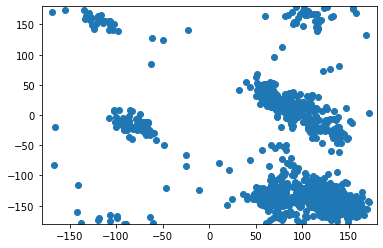

In [12]:
# twist angle example and plot:

from matplotlib import pyplot

phiList = []
psiList = []

for chain in structure.chains:
    for residue in chain.residues[1:-1]:
        phi, psi = getPhiPsi(residue)
        phiList.append(phi)
        psiList.append(psi)

pyplot.scatter(phiList, psiList) # creates a scatter plot
pyplot.axis([-180,180,-180,180]) # set bounds
pyplot.show()

In [13]:
# structure subsets

from Modelling import Structure, Chain, Residue, Atom

# function taking in structure and three other arguments
# arguments used to declare chain, residue, or atom 
# creates a new structure out of the subset section

def filterSubStructure(structure, chainCodes=None,
                       residueIds=None, atomNames=None):
    
    name = structure.name + '_filter'
    
    if chainCodes:
        name += ' ' + ','.join(chainCodes)
        chainCodes = set(chainCodes)
        
    if residueIds:
        name += ' ' + ','.join([str(x) for x in residueIds])
        residueIds = set(residueIds)
    
    if atomNames:
        name += ' ' + ','.join(atomNames)
        atomNames = set(atomNames)
    
    conf = structure.conformation
    pdbId = structure.pdbId
    
    # intialize a new structureObj for the filtered struc
    # keeping the same name and pdbId for the obj to indicate origin of data
    filterStruc = Structure(name=name, conformation=conf, pdbId=pdbId)
    
    # loop through all chains, residues, atoms of inputs
    # crearting lists of items to copy and use when creating filtered structure
    for chain in structure.chains:
        if chainCodes and (chain.code not in chainCodes):
            continue 
        
        includeResidues = [] 
        
        for residue in chain.residues:
            if residueIds and (residue.seqId not in residueIds):
                continue
            
            includeAtoms = []
            
            for atom in residue.atoms:
                if atomNames and (atom.name not in atomNames):
                    continue
                
                includeAtoms.append(atom)
            
            if includeAtoms:
                includeResidues.append((residue, includeAtoms))
        
        if includeResidues:
            filterChain = Chain(filterStruc, chain.code, chain.molType)
            
            for residue, atoms in includeResidues:
                filterResidue = Residue(filterChain, residue.seqId, residue.code)
                
                for atom in atoms:
                    coords = array(atom.coords)
                    Atom(filterResidue, name=atom.name, coords=coords, element=None)
                    
    return filterStruc
                

In [14]:
# filterStruc test example
'''
chainCodes = set(['A'])
residueIds = None  #No residue filter: all of them
atomNames = set(['N', 'CA', 'C']) # Heavy backbone atoms (not H)

chain_A_backbone = filterSubStructure(structure, chainCodes, residueIds, atomNames)
'''

"\nchainCodes = set(['A'])\nresidueIds = None  #No residue filter: all of them\natomNames = set(['N', 'CA', 'C']) # Heavy backbone atoms (not H)\n\nchain_A_backbone = filterSubStructure(structure, chainCodes, residueIds, atomNames)\n"

In [15]:
# def to copy a structure, uses the filterfunction
# passes no additional params other than structure
# results in a complete copy of the structure

def copyStructure(structure):
    
    return filterSubStructure(structure, None, None, None)

In [16]:
# centering coordinates

from numpy import zeros, ones, cross, sqrt, linalg, exp, identity

def centerCoords(coords, weights):
    
    wCoords = coords.transpose() * weights
    
    xyzTotals = wCoords.sum(axis=1)
    
    center = xyzTotals/sum(weights)
    
    coords -= center # moves all points so center is at 0,0,0
    
    return coords, center

In [17]:
# Aligning Coordinates

def alignCoords(coordsA, coordsB, weights=None):
    
    n = len(coordsA)
    if weights is None:
        weights = ones(n)
        
    rMat = dot(coordsB.transpose()*weights, coordsA)
    
    rMat1, scales, rMat2 = linalg.svd(rMat)
    
    sign = linalg.det(rMat) * linalg.det(rMat2)
    
    if sign < 0:
        rMat1[:,2] *= -1
        
    rotation = dot(rMat1, rMat2)
    
    coordsB = dot(coordsB, rotation)
    
    return rotation, coordsB

In [18]:
# Root-mean-square deviation

def calcRmsds(refCoords, allCoords, weights):
    
    rmsds = []
    totalWeight = sum(weights)
    totalSquares = zeros(refCoords.shape)
    
    for coords in allCoords:
        delta = coords-refCoords
        squares = delta * delta
        totalSquares += squares
        sumSquares = weights*squares.sum(axis=1)
        rmsds.append(sqrt(sum(sumSquares)/totalWeight))
        
        nStruct = len(allCoords)
        atomRmsds = sqrt(totalSquares.sum(axis=1)/nStruct)
        
    return rmsds, atomRmsds
    

In [19]:
# Aligning a structure ensemble 

# superimpose more than two coordinate arrays
# necessary to superpose all the conformations of a whole structure ensemble

def superimposeCoords(allCoords, weights, threshold=5.0):
    
    
    nStruct = len(allCoords)
    
    refCoords = allCoords[0]
    meanCoords = zeros(refCoords.shape)
    rotations = []
    
    for index, coords in enumerate(allCoords):
        if index == 0:
            rotation = identity(3)
        else:
            rotation, coords = alignCoords(refCoords, coords, weights)
            allCoords[index] = coords # Update to aligned
            
        rotations.append(rotation)
        meanCoords += coords
    
    meanCoords /= nStruct
    
    rmsds, atomRmsds = calcRmsds(meanCoords, allCoords, weights)
    
    bestRmsd = min(rmsds)
    bestIndex = rmsds.index(bestRmsd) # closest to mean
    bestCoords = allCoords[bestIndex]
    
    weightScale = atomRmsds/threshold #scale the RMDS value by a threshold value
    #new weights are calculated as the negative exponent of the scale values squared
    weights *= exp(-weightScale*weightScale)
    
    # atoms with small RMSD values will have the largest weights and as the variance 
    #   increases the weighting will diminish exponentially.
    
    meanCoords = bestCoords.copy()
    
    # don’t have to add best coords to the average, they are already in required array, 
    #        and because it is the reference there is no need to do the superimposition
    
    for index, coords in enumerate(allCoords):
        if index != bestIndex:
            rotation, coords = alignCoords(bestCoords, coords, weights)
            rotations[index] = rotation 
            allCoords[index] = coords # Update to aligned 
            meanCoords += coords
            
    # summation of coordinate arrays is divided by number of strucs 
    #     to get revised avg (mean) coord set
    
    meanCoords /= nStruct
    
    weights = ones(len(weights))
    rmsds, atomRmsds = calcRmsds(meanCoords, allCoords, weights)
    
    return allCoords, rmsds, atomRmsds, rotations

In [20]:
# superimpose structures
# applies the optimized superimposeCoords() to structure objects

def superimposeStructures(structures): # takes in list of structure objects
    # coords and atoms for strucobjs are extracted 
    # coords are superimposed
    # updates coords of original atom objects, resulting in structure rotation
    
    weights = None
    allCoords = []
    
    for structure in structures: 
        atoms, coords = getAtomCoords(structure)
        
        if weights is None:
            weights = ([ATOMIC_NUMS[atom.element] for atom in atoms])
            weights = array(weights)
        
        coords, center = centerCoords(coords, weights)
        allCoords.append(coords)
   
    # superimpose coords
    results = superimposeCoords(allCoords, weights)
    allCoords, rmsds, atomRmsds, rotations = results
    
    # loop through strucutre objects
    for i, structure in enumerate(structures):
        # get list of atoms and oldCoords (original)
        atoms, oldCoords = getAtomCoords(structure)
        # loop through atom index (j) and atoms
        for j, atom in enumerate(atoms):
            # update coords of atom obj to newly moved coords
            atom.coords = allCoords[i][j]
    
    return rmsds, atomRmsds

In [32]:
# testing superimposition function

from Modelling import getStructuresFromFile

# load file twice, into two strucObjs
strucA = getStructuresFromFile('examples/1A12.pdb')[0]
strucB = getStructuresFromFile('examples/1A12.pdb')[0]
rotateStructureNumPy(strucA, (1,0,0), pi/3) # only rotate one

rmsds, atomRmsds = superimposeStructures([strucA, strucB])

print(rmsds)


# can also get whole ensemble and test alignment of the strucObjs list

fileName = 'examples/1UST.pdb'
strucObjs = getStructuresFromFile(fileName)

rmsds, atomRmsds = superimposeStructures(strucObjs)
print("\nstrucObjs list example:\n", rmsds)

[7.678437039667182e-15, 7.68983871186093e-15]

strucObjs list example:
 [2.921344325211597, 2.3360837755497266, 2.5800238925790273, 2.368921677536993, 3.0340759139505296, 3.1599159667158374, 3.9985636965400695, 3.6476272866881705, 2.137260125371427, 3.039174809325437]


In [22]:
# homologous structure alignment

# find subsection of coords that is common between both struc
# do a seq align to find like residue subsections
# first must convert from structures and residues to one letter codes from 3 letter codes

# 3 to 1 dictionary
THREE_LETTER_TO_ONE = {'ALA':'A','CYS':'C','ASP':'D','GLU':'E',
                       'PHE':'F','GLY':'G','HIS':'H','ILE':'I',
                       'LYS':'K','LEU':'L','MET':'M','ASN':'N',
                       'PRO':'P','GLN':'Q','ARG':'R','SER':'S',
                       'THR':'T','VAL':'V','TRP':'W','TYR':'Y',
                       'G':'G','C':'C','A':'A','T':'T','U':'U'}
# loop through residues and convert to single letter codes
# use single letter string for each struc to align 

def getChainSequence(chain):
    
    letters = []
    
    for residue in chain.residues:
        code = residue.code
        letter = THREE_LETTER_TO_ONE.get(code, 'X') # passes X if single letter cannot be determined
        
    seq = ''.join(letters)
    
    return seq



from Alignments import sequenceAlign, BLOSUM62


def seqStructureBackboneAlign(chainA, chainB, 
                              atomNames=set(['CA', 'C', 'N']),
                              simMatrix=BLOSUM62):
   
    structureA = chainA.structure
    structureB = chainB.structure
    residuesA = chainA.residues
    residuesB = chainB.residues
    
    seqA = getChainSequence(chainA)
    seqB = getChainSequence(chainB)
    
    score, alignA, alignB = sequenceAlign(seqA, seqB, simMatrix)
    
    # empty lists to contain the location of the aligned residues
    pairedPosA = []
    pairedPosB = []
    # position counters as we loop through each seq
    posA = 0
    posB = 0
    
    for i in range(len(alignA)):
        # No dashes in both seq at the same location
        
        if alignA[i] == '-':
            posB += 1
        
        elif alignB[i] == '-':
            posA += 1
        
        else:
            pairedPosA.append(posA)
            pairedPosB.append(posB)
            posA += 1
            posB += 1
    
    # uses paired alignment positions, residue indices, to 
    #    get correct ResidueObj and put its number (seqId) in a list
    filterIdsA = [residuesA[p].seqId for p in pairedPosA]
    filterIdsB = [residuesB[p].seqId for p in pairedPosB]
    
    # filterSubStructure() used to define new Structure objects representing only backbone atoms.
    backboneStrucA = filterSubStructure(structureA, [chainA.code],
                                        filterIdsA, atomNames)
    backboneStrucB = filterSubStructure(structureB, [chainB.code],
                                        filterIdsB, atomNames)
    # collect list of atoms and coords for each backbone Struc
    atomsA, coordsA = getAtomCoords(backboneStrucA)
    atomsB, coordsB = getAtomCoords(backboneStrucB)
    weights = ones(len(atomsA)) # weights are all equal when initialized 
    
    # move backbone structures to the center
    coordsA, centerA = centerCoords(coordsA, weights)
    coordsB, centerB = centerCoords(coordsB, weights)
    
    # input a list of coords to superimnpose the necessary atoms
    coords = [coordsA, coordsB]
    c, rmsds, atomRmsds, rotations = superimposeCoords(coords, weights)
    
    #transform the original structures from a rotational transformation that was recorded
    affineTransformStructure(structureA, rotations[0], -centerA)
    affineTransformStructure(structureB, rotations[1], -centerB)
    
    return rmsds, atomRmsds

# example 
# not working... files are different sizes, chain lengths are different
#struc1 = getStructuresFromFile(downloadPDB('1UST'))[0]
#struc2 = getStructuresFromFile(downloadPDB('1HST'))[0]
#chain1 = struc1.getChain('A')
#chain2 = struc2.getChain('A')
#rmsds, atomRmsds = seqStructureBackboneAlign(chain1, chain2)
#print(rmsds)


In [27]:
# external macromolecular structure models

# examples are not working stright out of book



# structures in bio python

#from Bio import PDB

# make parser object that can make a PDB.Structure object using the data from a file.
#fileName = 'examples/1A12.pdb'
#parser = PDB.PDBParser()
#struc  = parser.get_structure('Name', fileName)
#conformation = struc[0]

#for chain in conformation:
    #for residue in chain:
        #atomNames = [a.name for a in residue]
        #print(chain.id, residue.id[1], residue.resname, atomNames)
        #caAtom = residue['CA']
        #print(caAtom.name, caAtom.coord, caAtom.bfactor)
        

#outFileName = 'test.pdb'
#writer = PDB.PDBIO()
#writer.set_structure(struc)
#writer.save(outFileName)




# structures in pymol

#import pymol

#pymol.finish_launching()

#fileName = downloadPDB('examples/1AFO')
#strucName = 'Glycophorin'
#pymol.cmd.load(fileName, strucName)

---
## Assignemnt:  Calculating Root-Mean-Square Deviation (RMSD) & aligning a Structure Ensemble 
---
### The Python code for calculating the sum of the square values along the spatial axis (i.e., x2 + y2 + z2)

In [43]:
# takes in structure and center of mass (xyz)
# calls the funciton to get the coordinates of the atoms 
from Modelling import getStructuresFromFile, Structure, Chain, Residue, Atom

from numpy import zeros, array, dot

# finds the center of mass (centroid) of a structure

ATOMIC_NUMS = {'H':1.0, 'C':12.0, 'N':14.0, 'O':16.0, 'P':31.0, 'S':32.0}

def getCenterOfMass(structure):
    
    centerOfMass = zeros(3, float)
    totalMass = 0.0
    
    for chain in structure.chains:
        for residue in chain.residues:
            for atom in residue.atoms:
                mass = ATOMIC_NUMS.get(atom.element, 12.0)
                centerOfMass += mass * atom.coords
                totalMass += mass
                
    centerOfMass /= totalMass
    
    return centerOfMass

def getAtomCoords(structure):
    
    coords = []
    atoms = []
    
    for chain in structure.chains:
        for residue in chain.residues:
            for atom in residue.atoms:
                coords.append(atom.coords)
                atoms.append(atom)
                
    return atoms, array(coords) 

def getSumSquares(structure, xyz):
    
    xyz = array(xyz)
    atoms, coords = getAtomCoords(structure)
    
    deltas = coords - xyz
    squares = deltas * deltas
    sumSquares = squares.sum(axis=1)
    
    return sumSquares

strucObj = getStructuresFromFile('examples/1A12.pdb')

structure1 = getStructuresFromFile('examples/1A12.pdb')[0]

center_coords = getCenterOfMass(structure1)

sumOfSquares = getSumSquares(structure1, center_coords)
print(sumOfSquares)



[1329.86571288 1272.32916245 1191.10659995 ...  296.44373987  276.36671847
  216.2503414 ]


---
### The Python code that use "for" loops for getting the summed values of all and then give a single value (divided by the total weight to find the average atomic square deviation)

AND

### The Python code for aligning all the coordinate arrays to the reference set

In [36]:
from numpy import zeros, ones, cross, sqrt, linalg, exp, identity
from Modelling import getStructuresFromFile

# Aligning Coordinates
def alignCoords(coordsA, coordsB, weights=None):
    
    n = len(coordsA)
    if weights is None:
        weights = ones(n)
        
    rMat = dot(coordsB.transpose()*weights, coordsA)
    
    rMat1, scales, rMat2 = linalg.svd(rMat)
    
    sign = linalg.det(rMat) * linalg.det(rMat2)
    
    if sign < 0:
        rMat1[:,2] *= -1
        
    rotation = dot(rMat1, rMat2)
    
    coordsB = dot(coordsB, rotation)
    
    return rotation, coordsB


# centering coordinates
def centerCoords(coords, weights):
    
    wCoords = coords.transpose() * weights
    
    xyzTotals = wCoords.sum(axis=1)
    
    center = xyzTotals/sum(weights)
    
    coords -= center # moves all points so center is at 0,0,0
    
    return coords, center


# Root-mean-square deviation
def calcRmsds(refCoords, allCoords, weights):
    
    rmsds = []
    totalWeight = sum(weights)
    totalSquares = zeros(refCoords.shape)
    
    for coords in allCoords:
        delta = coords-refCoords
        squares = delta * delta
        totalSquares += squares
        sumSquares = weights*squares.sum(axis=1)
        rmsds.append(sqrt(sum(sumSquares)/totalWeight))
        
        nStruct = len(allCoords)
        atomRmsds = sqrt(totalSquares.sum(axis=1)/nStruct)
        
    return rmsds, atomRmsds



# Aligning a structure ensemble:

# superimpose more than two coordinate arrays
# necessary to superpose all the conformations of a whole structure ensemble
def superimposeCoords(allCoords, weights, threshold=5.0):
    
    nStruct = len(allCoords)
    
    refCoords = allCoords[0]
    meanCoords = zeros(refCoords.shape)
    rotations = []
    
    for index, coords in enumerate(allCoords):
        if index == 0:
            rotation = identity(3)
        else:
            rotation, coords = alignCoords(refCoords, coords, weights)
            allCoords[index] = coords # Update to aligned
            
        rotations.append(rotation)
        meanCoords += coords
    
    meanCoords /= nStruct
    
    rmsds, atomRmsds = calcRmsds(meanCoords, allCoords, weights)
    
    bestRmsd = min(rmsds)
    bestIndex = rmsds.index(bestRmsd) # closest to mean
    bestCoords = allCoords[bestIndex]
    
    weightScale = atomRmsds/threshold #scale the RMDS value by a threshold value
    #new weights are calculated as the negative exponent of the scale values squared
    weights *= exp(-weightScale*weightScale)
    
    # atoms with small RMSD values will have the largest weights and as the variance 
    #   increases the weighting will diminish exponentially.
    
    meanCoords = bestCoords.copy()
    
    # don’t have to add best coords to the average, they are already in required array, 
    #        and because it is the reference there is no need to do the superimposition
    
    for index, coords in enumerate(allCoords):
        if index != bestIndex:
            rotation, coords = alignCoords(bestCoords, coords, weights)
            rotations[index] = rotation 
            allCoords[index] = coords # Update to aligned 
            meanCoords += coords
            
    # summation of coordinate arrays is divided by number of strucs 
    #     to get revised avg (mean) coord set
    
    meanCoords /= nStruct
    
    weights = ones(len(weights))
    rmsds, atomRmsds = calcRmsds(meanCoords, allCoords, weights)
    
    return allCoords, rmsds, atomRmsds, rotations

# superimpose structures
# applies the optimized superimposeCoords() to structure objects

def superimposeStructures(structures): # takes in list of structure objects
    # coords and atoms for strucobjs are extracted 
    # coords are superimposed
    # updates coords of original atom objects, resulting in structure rotation
    
    weights = None
    allCoords = []
    
    for structure in structures: 
        atoms, coords = getAtomCoords(structure)
        
        if weights is None:
            weights = ([ATOMIC_NUMS[atom.element] for atom in atoms])
            weights = array(weights)
        
        coords, center = centerCoords(coords, weights)
        allCoords.append(coords)
   
    # superimpose coords
    results = superimposeCoords(allCoords, weights)
    allCoords, rmsds, atomRmsds, rotations = results
    
    # loop through strucutre objects
    for i, structure in enumerate(structures):
        # get list of atoms and oldCoords (original)
        atoms, oldCoords = getAtomCoords(structure)
        # loop through atom index (j) and atoms
        for j, atom in enumerate(atoms):
            # update coords of atom obj to newly moved coords
            atom.coords = allCoords[i][j]
    
    return rmsds, atomRmsds

# load file twice, into two strucObjs
strucA = getStructuresFromFile('examples/1A12.pdb')[0]
strucB = getStructuresFromFile('examples/1A12.pdb')[0]

# calls function to rotate
# only rotate one so we can measure the difference in the rmsds value

rotateStructureNumPy(strucA, (1,0,0), pi/3) 

# aligns structures, by moving coordinates in 3d space
rmsds, atomRmsds = superimposeStructures([strucA, strucB])

print(rmsds)

print(atomRmsds)



[7.678437039667182e-15, 7.68983871186093e-15]
[9.91025644e-15 9.05767819e-15 9.33644097e-15 ... 5.36824692e-15
 5.37183335e-15 5.51994135e-15]
